Refer "Alpha in terms of time", "Limb Darkening", "Night Sky Coordinates of the Planet w.r.t the Star" notebooks for this

In [140]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import sys
import copy
import time
import random
from scipy.integrate import solve_ivp

np.set_printoptions(threshold=sys.maxsize)

In [141]:
def der_alpha(t, alpha, e, P): 
    return (2 * np.pi / P / (1 - e*e)**1.5) * (1 + e*np.cos(alpha))**2

In [142]:
class planet(object):
    def __init__(self, semi_major, eccentricity, periastron_angle, inclination, planet_radius):
        self.a = semi_major
        self.e = eccentricity
        self.w = periastron_angle
        self.i = inclination
        self.Rp = planet_radius
        
    def reduce_distances(self, Rs):
        self.a /= Rs
        self.Rp /= Rs

In [143]:
class system(object):
    def __init__(self, star_radius, star_mass, planets, time_split=100, img_split=100):
        try:
            self.n = len(planets)
#             period_constant = (2 * np.pi) / ((scipy.constants.G * star_mass)**0.5)
            period_constant = 200.0 / (star_mass)**0.5
            self.a, self.e, self.w, self.i, self.Rp, self.P  = ([] for i in range(6))
            for planet in planets:
                planet.reduce_distances(star_radius)
                self.a.append(planet.a)
                self.e.append(planet.e)
                self.w.append(planet.w)
                self.i.append(planet.i)
                self.Rp.append(planet.Rp)
                self.P.append(planet.a**1.5 * period_constant)
            
            self.time_split = int(time_split)
            self.split = int(img_split)
            self.u = [0.1, 0.2]

            self.init_alpha_wrt_time()
            self.init_stellar_limb_darkening()
        except:
            raise NameError('Check the input again! or try to debug')
        
        
    def init_alpha_wrt_time(self):
        self.total_time = max(self.P)
        t_span = (0, self.total_time)
        t = np.linspace(0, self.total_time, self.time_split+1)
        y0 = np.array([0])
        
        self.alpha_array = []
        for i in range(self.n):
            sol = solve_ivp(der_alpha, t_span, y0, t_eval = t, args = (self.e[i], self.P[i]))
            self.alpha_array.append(sol.y[0])
            print(len(sol.y[0]))

        self.time_array = sol.t
        print(len(sol.t))
        
    def init_stellar_limb_darkening(self):
        self.star = np.zeros((2*self.split+1, 2*self.split+1))
        self.lum_total = 0
        for i in range(-self.split, self.split+1):
            rg_j = abs(int((self.split**2 - i**2)**0.5))
            for j in range(-rg_j, rg_j+1):
                x = (i)/self.split
                y = (j)/self.split
                cosine = abs((1 - x**2 - y**2)**0.5)
                lum = 1 - self.u[0]*(1 - cosine) - self.u[1]*((1 - cosine)**2)
                self.lum_total += lum
                self.star[self.split+i][self.split+j] = lum


    def output(self, time):
        cur_star = copy.deepcopy(self.star)
        cur_total = copy.deepcopy(self.lum_total)
        t = time - int(time/self.total_time)
        l = time * self.time_split / self.total_time
        
        for k in range(self.n):
            alpha = self.alpha_array[k][int(l)]

            angle = alpha + self.w[k]
            r = self.a[k] * (1 - self.e[k]**2) / (1 + self.e[k]*np.cos(alpha))
            orig_x = r * np.cos(angle)
            orig_y = r * np.sin(angle) * np.cos(self.i[k])

            if orig_y*(self.i[k] - (np.pi/2)) > 0: # Only the part of orbit which is away from us
                continue
            if orig_x**2 + orig_y**2 > 2 * ((1 + self.Rp[k])**2):
                continue
            x, y, Rp = int(orig_x*self.split), int(orig_y*self.split), int(self.Rp[k]*self.split)
            for i in range(-Rp, Rp+1):
                if y-i >= -self.split and y-i <= self.split:
                    rg_j = abs(int((Rp**2 - i**2)**0.5))
                    for j in range(-rg_j, rg_j+1):
                        if x+j >= -self.split and x+j <= self.split:
                            m = self.split - y + i
                            n = self.split + x + j
                            lum = cur_star[m][n]
                            cur_total -= lum
                            cur_star[m][n] = 0
        return cur_total

In [144]:
planet1 = planet(semi_major = 5, \
                 eccentricity = 0.04, \
                 periastron_angle = 270.0*(np.pi/180), \
                 inclination = 89.9*(np.pi/180), \
                 planet_radius = 0.1)

planet2 = planet(semi_major = 5*(3**(2/3)), \
                 eccentricity = 0.04, \
                 periastron_angle = 270.0*(np.pi/180), \
                 inclination = 89.9*(np.pi/180), \
                 planet_radius = 0.05)

In [145]:
print(time.localtime())
exo = system(star_radius = 1.0, \
             star_mass = 40, \
             planets = [planet1, planet2], \
             time_split = 10000, \
             img_split = 100)
times = exo.time_array
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=34, tm_wday=0, tm_yday=181, tm_isdst=0)
10001
10001
10001
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=34, tm_wday=0, tm_yday=181, tm_isdst=0)


In [146]:
print(time.localtime())
total_lum = exo.lum_total
lum = []
for t in times:
    lum.append(exo.output(t))
lum = np.array(lum)/total_lum
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=34, tm_wday=0, tm_yday=181, tm_isdst=0)
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=35, tm_wday=0, tm_yday=181, tm_isdst=0)


time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=35, tm_wday=0, tm_yday=181, tm_isdst=0)
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=35, tm_wday=0, tm_yday=181, tm_isdst=0)


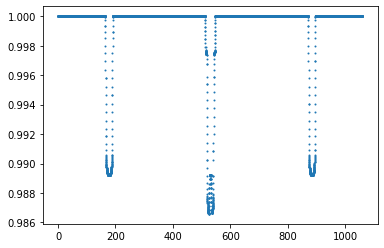

In [147]:
print(time.localtime())
plt.scatter(times, lum, s=1)
print(time.localtime())

time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=35, tm_wday=0, tm_yday=181, tm_isdst=0)
time.struct_time(tm_year=2020, tm_mon=6, tm_mday=29, tm_hour=0, tm_min=53, tm_sec=35, tm_wday=0, tm_yday=181, tm_isdst=0)


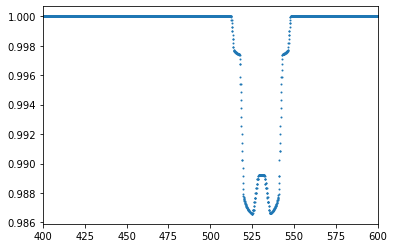

In [148]:
print(time.localtime())
plt.scatter(times, lum, s=1)
plt.xlim(400,600)
print(time.localtime())

<font size="4">For two planets where one crosses the other during the transit period</font>